## Установка библиотек

In [1]:
!pip install mrjob
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 KB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 1.2 MB/s eta 0:00:0000:0100:01


## Загрузка данных

Создаем папку для будущих данных

In [2]:
!hadoop fs -mkdir /starwars

2023-11-29 14:44:13 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
!hadoop fs -ls /

2023-11-29 14:44:18 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
drwxr-xr-x   - root supergroup          0 2023-11-29 14:44 /starwars
drwx-wx-wx   - root supergroup          0 2023-11-29 14:17 /tmp


Загружаем файлы с данными из локальной файловой системы на hdfs

In [5]:
!hadoop fs -put ./archive/SW_EpisodeIV.txt /starwars
!hadoop fs -put ./archive/SW_EpisodeV.txt /starwars
!hadoop fs -put ./archive/SW_EpisodeVI.txt /starwars

2023-11-29 14:48:35 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 14:48:37 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 14:48:38 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Проверим, что файлики действительно появились в hdfs

In [6]:
!hadoop fs -ls /starwars

2023-11-29 14:49:12 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
-rw-r--r--   3 root supergroup      78278 2023-11-29 14:48 /starwars/SW_EpisodeIV.txt
-rw-r--r--   3 root supergroup      55487 2023-11-29 14:48 /starwars/SW_EpisodeV.txt
-rw-r--r--   3 root supergroup      48176 2023-11-29 14:48 /starwars/SW_EpisodeVI.txt


### Пути до файлов

Для удобства вынесем пути до файлов в переменные

In [121]:
# original data files
original_e4 = './archive/SW_EpisodeIV.txt'
original_e5 = './archive/SW_EpisodeV.txt'
original_e6 = './archive/SW_EpisodeVI.txt'

# hdfs data files
hdfs_e4 = 'hdfs://namenode:8020/starwars/SW_EpisodeIV.txt'
hdfs_e5 = 'hdfs://namenode:8020/starwars/SW_EpisodeV.txt'
hdfs_e6 = 'hdfs://namenode:8020/starwars/SW_EpisodeVI.txt'

## Задание 1

## Скрипт-решение: топ самых говорливых персонажей

In [35]:
%%file most_talkative_characters.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep

TOP_N = 20

class MRMostTalkativeCharacters(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_characters,
                   combiner=self.combiner_count_phrases,
                   reducer=self.reducer_count_phrases),
            MRStep(reducer=self.reducer_top_talkative_characters)
        ]

    def mapper_get_characters(self, _, line):
        line_words = line.replace('"', '').split()
        character = line_words[1]
        yield (character, 1)

    def combiner_count_phrases(self, character, phrases_counts):
        # optimization: sum the characters we've seen so far
        yield (character, sum(phrases_counts))

    def reducer_count_phrases(self, character, phrases_counts):
        # send all (character, phrases_counts) pairs to the same reducer.
        yield None, (character, sum(phrases_counts))

    # discard the key; it is just None
    def reducer_top_talkative_characters(self, _, character_phrases_count_pairs):
        # each item of character_phrases_count_pairs is (character, total_phrases_count)
        # convert to list bc 'generator' object is not subscriptable
        character_phrases_count_pairs = list(character_phrases_count_pairs)
        
        # sort by total phrases count
        character_phrases_count_pairs.sort(
            key=lambda pair: pair[1],
            reverse=True
        )

        # get top N talkative characters
        top_talkative_characters = character_phrases_count_pairs[:TOP_N]
        
        # return the result
        for character_count_pair in top_talkative_characters:
            yield character_count_pair


if __name__ == '__main__':
    MRMostTalkativeCharacters.run()

Overwriting most_talkative_characters.py


## Локальное тестирование

### Запуск скриптов

In [123]:
# task1 local results paths
t1_local_res_e4 = './results/task-1/local/SW_EpisodeIV_res.txt'
t1_local_res_e5 = './results/task-1/local/SW_EpisodeV_res.txt'
t1_local_res_e6 = './results/task-1/local/SW_EpisodeVI_res.txt'
t1_local_res_all = './results/task-1/local/SW_All_Episodes_res.txt'

По каждому эпизоду

In [112]:
!python3 most_talkative_characters.py $original_e4 > $t1_local_res_e4

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.163839.694419
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.163839.694419/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.163839.694419/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.163839.694419...


In [113]:
!python3 most_talkative_characters.py $original_e5 > $t1_local_res_e5

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.163900.568568
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.163900.568568/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.163900.568568/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.163900.568568...


In [114]:
!python3 most_talkative_characters.py $original_e6 > $t1_local_res_e6

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.163907.890349
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.163907.890349/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.163907.890349/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.163907.890349...


По всем трем эпизодам

In [115]:
!python3 most_talkative_characters.py $original_e4 $original_e5 $original_e6 > $t1_local_res_all

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.163951.091719
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.163951.091719/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.163951.091719/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.163951.091719...


## Тестирование на кластере

### Изменение конфигурации

Увеличим число mapper'ов и reducer'ов, изменив конфигурацию

In [87]:
%%file config-t1.conf

runners:
  hadoop: # also works for emr runner
    jobconf:
      mapreduce.job.maps: 2
      mapreduce.job.reduces: 2

Writing config-t1.conf


### Запуск скриптов

In [122]:
# task1 hdfs results paths
t1_hdfs_res_e4 = '/starwars/results/SW_EpisodeIV_res.txt'
t1_hdfs_res_e5 = '/starwars/results/SW_EpisodeV_res.txt'
t1_hdfs_res_e6 = '/starwars/results/SW_EpisodeVI_res.txt'
t1_hdfs_res_all = '/starwars/results/SW_All_Episodes_res.txt'

По каждому эпизоду. Результаты сохраняем в файловую систему hdfs.

In [124]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e4 --conf-path config-t1.conf --output $t1_hdfs_res_e4

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.164817.992037
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.164817.992037/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.164817.992037/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar1422273847618835929/] [] /tmp/streamjob7853467494765559939.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/h

In [125]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e5 --conf-path config-t1.conf --output $t1_hdfs_res_e5

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.165210.819613
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.165210.819613/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.165210.819613/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar8130186236309935760/] [] /tmp/streamjob6129611118415792693.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/h

In [126]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e6 --conf-path config-t1.conf --output $t1_hdfs_res_e6

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.165436.581167
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.165436.581167/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.165436.581167/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar2897489328345726880/] [] /tmp/streamjob2869886251340831156.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/h

По всем эпизодам

In [131]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e4 $hdfs_e5 $hdfs_e6 --conf-path config-t1.conf --output $t1_hdfs_res_all

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.165525.996105
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.165525.996105/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.165525.996105/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar3264290454754937876/] [] /tmp/streamjob5419003149763314898.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/h

### Просмотр результатов выполнения

In [98]:
!hadoop fs -cat /starwars/results/SW_All_Episodes_res.txt/part-00000

2023-11-29 19:24:21 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"LUKE"	494
"HAN"	460
"THREEPIO"	301
"LEIA"	227
"VADER"	140
"BEN"	115
"LANDO"	101
"RED"	52
"YODA"	49
"EMPEROR"	44
"BIGGS"	34
"WEDGE"	33
"PIETT"	31
"TARKIN"	28
"JABBA"	26
"OWEN"	25
"GOLD"	23
"CREATURE"	22
"TROOPER"	20
"OFFICER"	14


In [100]:
!hadoop fs -cat /starwars/results/SW_All_Episodes_res.txt/part-00001

2023-11-29 19:25:00 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Все успешно. Результаты попали в одну часть.

### Скачивание файлов

Скачаем полученные в результате тестирования файлы в локально на компьютер

In [103]:
!hadoop fs -get hdfs://namenode:8020/starwars/results/SW_EpisodeIV_res.txt ./results/hdfs/SW_EpisodeIV_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/SW_EpisodeV_res.txt ./results/hdfs/SW_EpisodeV_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/SW_EpisodeVI_res.txt ./results/hdfs/SW_EpisodeVI_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/SW_All_Episodes_res.txt ./results/hdfs/SW_All_Episodes_res.txt

2023-11-29 19:27:37 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 19:27:38 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 19:27:39 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 19:27:40 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Построение графиков

In [41]:
from typing import Tuple, List

In [55]:
def results_parsing(res_file_path: str) -> Tuple[List, List]:
    characters = []
    phrases_counts = []

    with open(res_file_path) as res_file:
        for line in res_file:
            line_words = line.split('\t')

            character = line_words[0].replace('"', '')
            characters.append(character)
            
            phrases_count = int(line_words[1].replace('\n', ''))
            phrases_counts.append(phrases_count)
    return characters, phrases_counts

In [32]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 876.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.2/293.2 KB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 1.2 MB/s eta 0:00:0000:0100:01


In [82]:
from matplotlib import pyplot as plt

def build_graphic(characters: List, phrases_counts: List):
    plt.figure(figsize=(20,5))
    plt.bar(characters, phrases_counts, width=0.6)
    plt.xlabel('Character')
    plt.ylabel('Number of phrases')
    plt.title('Characters phrases counts')
    plt.show()

In [46]:
def results_graphic(res_file_path: str):
    characters, phrases_counts = results_parsing(res_file_path)
    build_graphic(characters, phrases_counts)

Построим графики для каждого файла с результатами. Для каждого эпизода выведем график с результатами локального тестирования и график с результатами тестирования на кластере. Убедимся, что результаты совпадают.

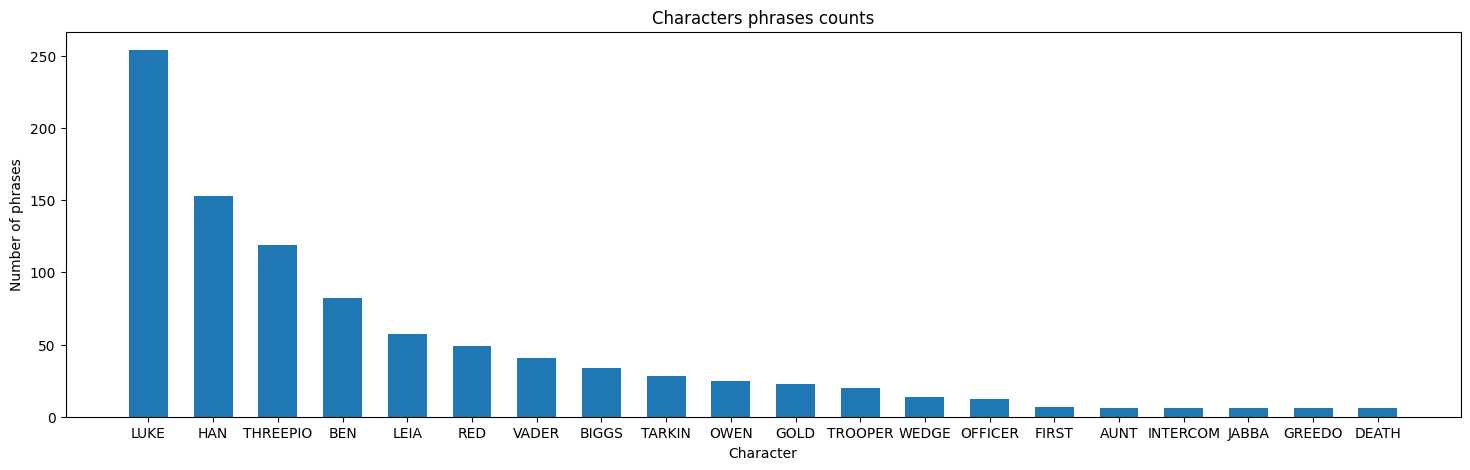

In [127]:
results_graphic(t1_local_res_e4)

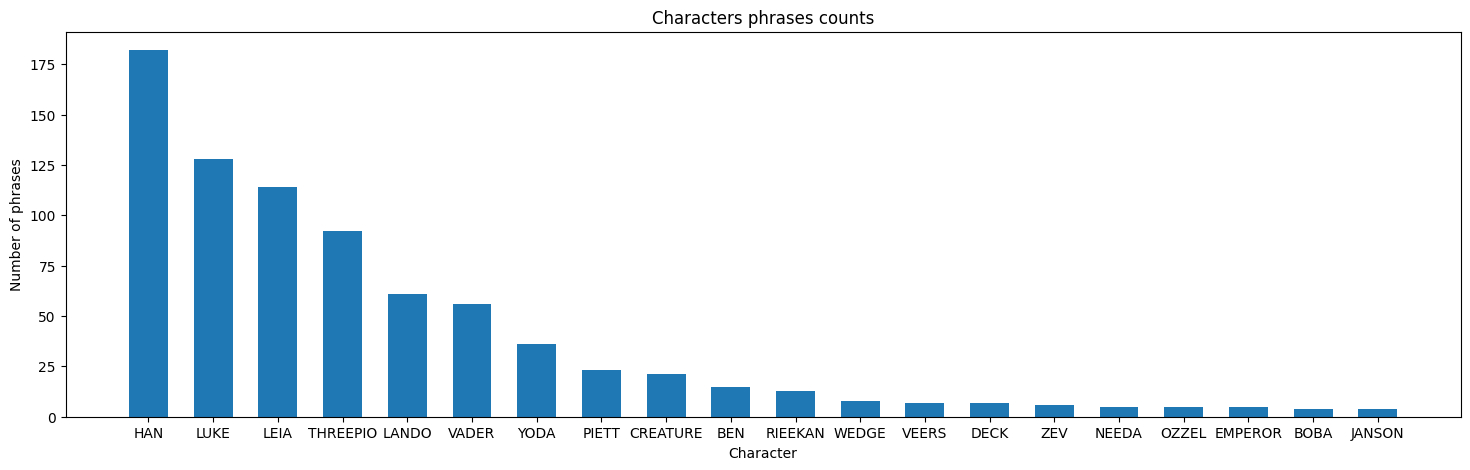

In [128]:
results_graphic(t1_local_res_e5)

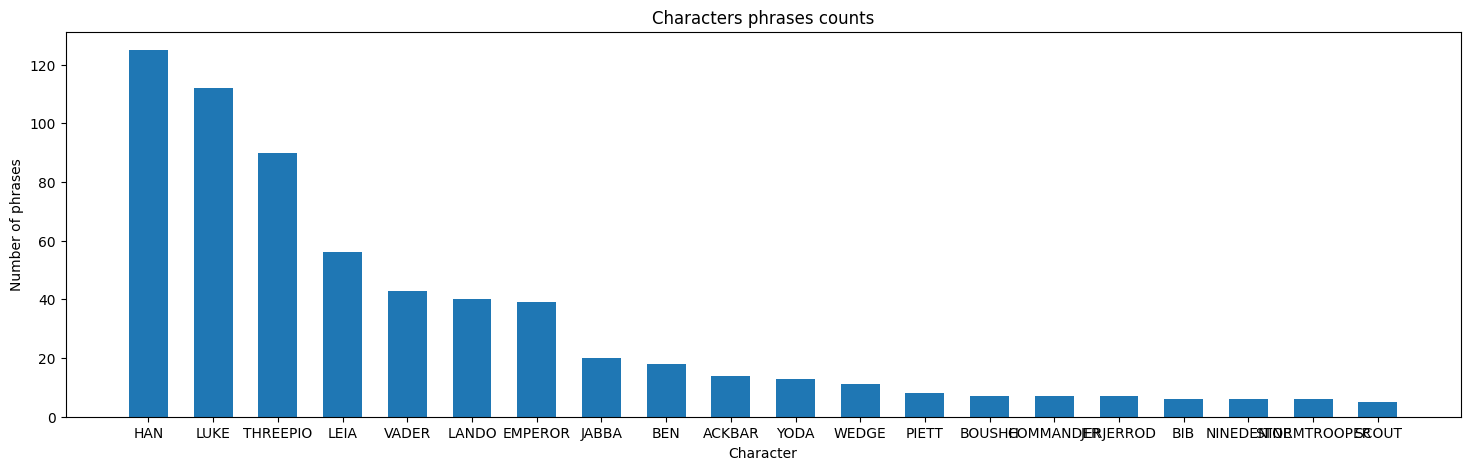

In [129]:
results_graphic(t1_local_res_e6)

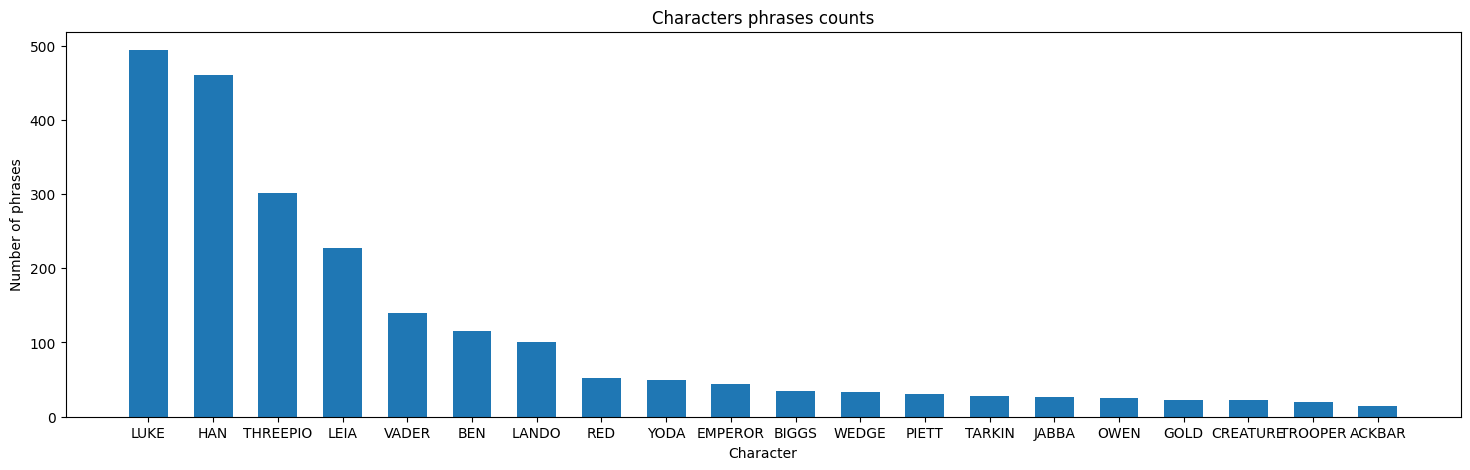

In [130]:
results_graphic(t1_local_res_all)

## Задание 2

## Скрипт-решение: самая длинная фраза каждого персонажа

In [ ]:
%%file most_talkative_characters.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep

class MRLongestCharacterPhrase(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_character_phrase,
                   combiner=self.combiner_count_phrases,
                   reducer=self.reducer_count_phrases),
            MRStep(reducer=self.reducer_top_talkative_characters)
        ]

    def mapper_get_character_phrase(self, _, line):
        line_words = line.replace('"', '').split()
        character = line_words[1]
        phrase = ' '.join(line_words[2:])
        yield (character, phrase)

    def combiner_longest_phrase(self, character, phrases):
        # optimization: longest character phrase we've seen so far
        longest_character_phrase = max(phrases, key=len)
        yield (character, longest_character_phrase)

    def reducer_longest_phrase(self, character, longest_phrases):
        # the longest character phrase among all data
        longest_character_phrase = max(phrases, key=len)
        yield None, (character, longest_character_phrase)

    # discard the key; it is just None
    def reducer_top_talkative_characters(self, _, character_phrases_count_pairs):
        # each item of character_phrases_count_pairs is (character, total_phrases_count)
        # convert to list bc 'generator' object is not subscriptable
        character_phrases_count_pairs = list(character_phrases_count_pairs)
        
        # sort by total phrases count
        character_phrases_count_pairs.sort(
            key=lambda pair: pair[1],
            reverse=True
        )

        # get top N talkative characters
        top_talkative_characters = character_phrases_count_pairs[:TOP_N]
        
        # return the result
        for character_count_pair in top_talkative_characters:
            yield character_count_pair


if __name__ == '__main__':
    MRLongestCharacterPhrase.run()